# 프로젝트: 인물 모드 문제점 찾기

In [1]:
from importlib.metadata import version
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## 1. 인물모드 직접 해 보기 (인물, 고양이1, 고양이2)
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### 이미지 준비

In [2]:
# image load func def
def img_load(image):
    img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/{image}.png'  
    img_orig = cv2.imread(img_path)
    
    return img_orig, img_path

In [3]:
img_orig1, img_path1 = img_load("my_image")
img_orig2, img_path2 = img_load("dog")
img_orig3, img_path3 = img_load("cat")

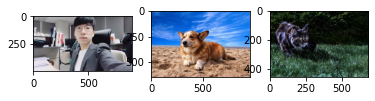

In [4]:
# image show
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

### 모델 준비

In [5]:
# model download
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
# urllib.request.urlretrieve(model_url, model_file) 

In [6]:
# 모델 선언
model = semantic_segmentation() 

# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

### 데이터 모델에 입력

In [7]:
print(img_orig1.shape)
print(img_orig2.shape)
print(img_orig3.shape)

(500, 892, 3)
(642, 960, 3)
(454, 680, 3)


In [8]:
segvalues1, output1 = model.segmentAsPascalvoc(img_path1)
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

In [9]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

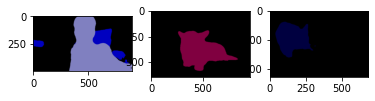

In [10]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.subplot(1,3,1)
plt.imshow(output1)
plt.subplot(1,3,2)
plt.imshow(output2)
plt.subplot(1,3,3)
plt.imshow(output3)
plt.show()

In [11]:
# 클래스 저장
class_ids1 = segvalues1["class_ids"]
class_ids2 = segvalues2["class_ids"]
class_ids3 = segvalues3["class_ids"]

In [12]:
# class id 확인
for i, class_id in enumerate([class_ids1, class_ids2, class_ids3]):
    print(f"class id")
    for _ in class_id:
        print(f"   {_} : {LABEL_NAMES[_]}")

class id
   0 : background
   9 : chair
   15 : person
class id
   0 : background
   12 : dog
class id
   0 : background
   8 : cat


### 색상

In [13]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [14]:
# person colormap
print(colormap[15])

# dog colormap
print(colormap[12])

# cat colormap
print(colormap[8])

[192 128 128]
[ 64   0 128]
[64  0  0]


In [15]:
# 색상 변경
## 사람
seg_color_person = (128, 128, 192) # BGR(192, 128, 128) -> RGB(128, 128, 192) 

## 강아지 
seg_color_dog = (128, 0, 64) # BGR(64, 0, 128) -> RGB(128, 0, 64)

## cat
seg_color_cat = (0, 0, 64) # BGR(64, 0, 0) -> RGB(0, 0, 64)

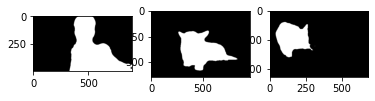

In [16]:
plt.subplot(1,3,1)
seg_map1 = np.all(output1==seg_color_person, axis=-1) 
plt.imshow(seg_map1, cmap='gray')

plt.subplot(1,3,2)
seg_map2 = np.all(output2==seg_color_dog, axis=-1) 
plt.imshow(seg_map2, cmap='gray')

plt.subplot(1,3,3)
seg_map3 = np.all(output3==seg_color_cat, axis=-1) 
plt.imshow(seg_map3, cmap='gray')
plt.show()

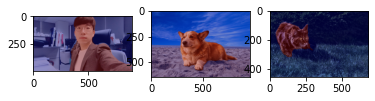

In [17]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show1 = img_orig1.copy()
img_show2 = img_orig2.copy()
img_show3 = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask1 = seg_map1.astype(np.uint8) * 255
img_mask2 = seg_map2.astype(np.uint8) * 255
img_mask3 = seg_map3.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))

plt.show()

### 배경 blur

In [18]:
# background blur func def
def back_blur(img_orig, img_mask):
    img_orig_blur = cv2.blur(img_orig, (13,13)) # 이미지 흐리게
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) #BGR -> RGB
    img_bg_mask = cv2.bitwise_not(img_mask_color) # 배경이 0, 사람이 255 -> 배경이 255, 사람 0
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경만 있는
    return img_mask_color, img_bg_blur

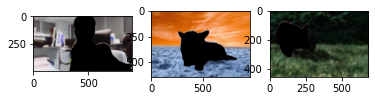

In [19]:
img_mask_color1, img_bg_blur1 = back_blur(img_orig1, img_mask1)
img_mask_color2, img_bg_blur2 = back_blur(img_orig2, img_mask2)
img_mask_color3, img_bg_blur3 = back_blur(img_orig3, img_mask3)

plt.subplot(1,3,1)
plt.imshow(img_bg_blur1)

plt.subplot(1,3,2)
plt.imshow(img_bg_blur2)

plt.subplot(1,3,3)
plt.imshow(img_bg_blur3)

plt.show()

### 흐린 배경 + 객체 합치기

In [20]:
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

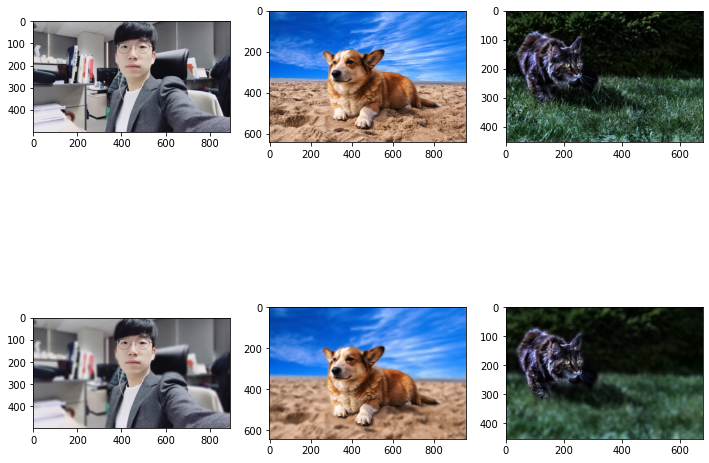

In [21]:
# 원본 vs blur 처리

plt.figure(figsize=(12, 10))
plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))

plt.show()

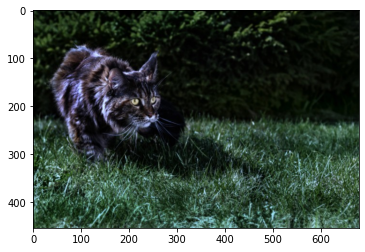

In [84]:
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

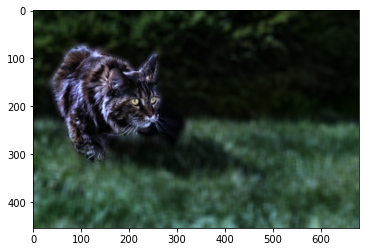

In [83]:
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

### 함수화

In [69]:
def background_blur(img_path, model_path):
    # img load
    img = cv2.imread(image_path)
    
    # model load
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_path)
    
    # segementation
    seg_values, output = model.segmentAsPascalvoc(image_path)
    
    # img blur
    img_blur = cv2.blur(img, (15, 15))
    
    # mask 
    ## person = [128, 128, 192], cat = [0, 0, 64], dog = [128, 0, 64]
    img_mask = np.all(output1==[128, 128, 192], axis=-1).astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color) 
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) 
    
    # concat
    img_concat = np.where(img_mask_color == 255, img, img_bg_blur)
    
    return img_concat
    

-> 사람의 경우 뒤에 패딩부분이 제대로 blur처리가 안됨.

-> 개의 경우 깔끔하게 잘된것을 확인.

-> 고양이는 배경과 비슷한 것을 가져왔는데도 segmentation 잘 된 것을 확인할 수 있음.

## 2. 인물 + 고양이에서 고양이에 대한 아웃 포커싱

In [22]:
img_orig4, img_path4 = img_load('cat_person')

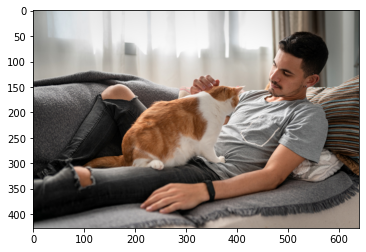

In [23]:
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
segvalues4, output4 = model.segmentAsPascalvoc(img_path4)

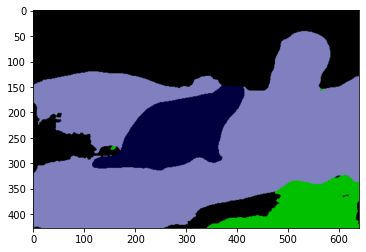

In [25]:
plt.imshow(output4)
plt.show()

In [26]:
for class_id in segvalues4['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
person
sofa


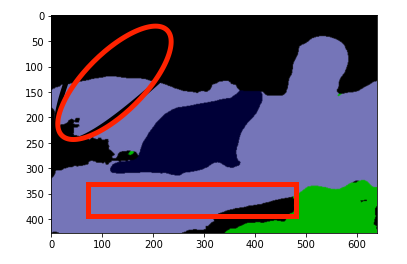
- 체크된 부분은 소파인데 사람으로 인식

(427, 640)


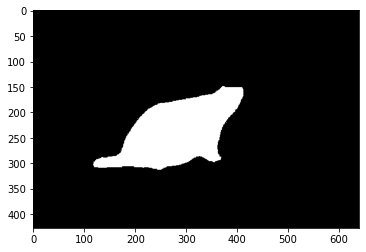

In [28]:
# seg_color_cat 그대로 사용
seg_map4 = np.all(output4==seg_color_cat, axis=-1) 
print(seg_map4.shape) 
plt.imshow(seg_map4, cmap='gray')
plt.show()

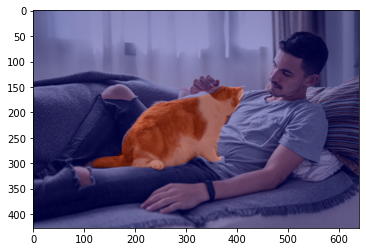

In [29]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show4 = img_orig4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask4 = seg_map4.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

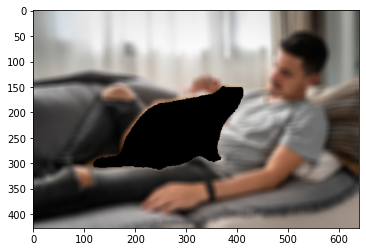

In [30]:
img_mask_color4, img_bg_blur4 = back_blur(img_orig4, img_mask4)

plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
img_concat4 = np.where(img_mask_color4==255, img_orig4, img_bg_blur4)

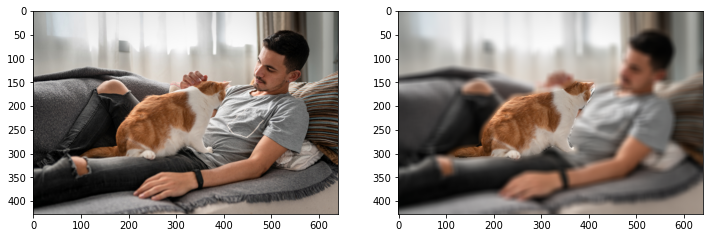

In [32]:
# 원본 vs 고양이만 

plt.figure(figsize = (12, 10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))

-> 뭔가 조금 이질감이 든다. 고양이도 사람손이 붙은 쪽은 잘렸다. 왜??

## 배경 크로마키 합성하기 (사람)

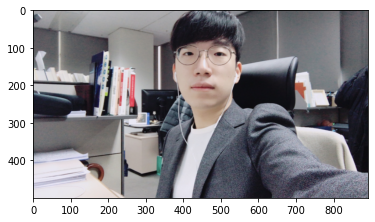

In [33]:
# 원본 사진
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
for class_id in segvalues1['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


(500, 892)


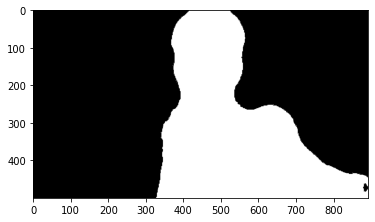

In [35]:
# seg_color_person 그대로 이용
seg_map1 = np.all(output1==seg_color_person, axis=-1) 
print(seg_map1.shape) 
plt.imshow(seg_map1, cmap='gray')
plt.show()

In [36]:
img_orig5, img_path5 = img_load("background")

(500, 892, 3)


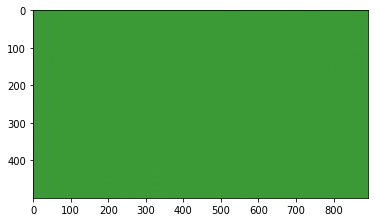

In [38]:
# image resize
img_orig5 = cv2.resize(img_orig5, (892,500))

print(img_orig5.shape)
plt.imshow(cv2.cvtColor(img_orig5, cv2.COLOR_BGR2RGB))
plt.show()

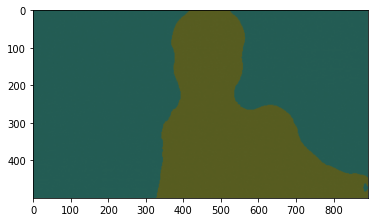

In [39]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show5 = img_orig5.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask5 = seg_map1.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask5 = cv2.applyColorMap(img_mask5, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show5 = cv2.addWeighted(img_show5, 0.6, color_mask5, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB))
plt.show()

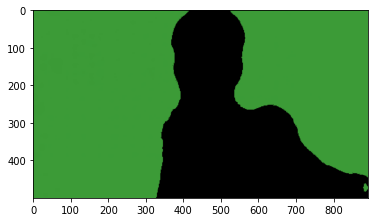

In [40]:
img_mask_color5, img_bg_blur5 = back_blur(img_orig5, img_mask5)

plt.imshow(cv2.cvtColor(img_bg_blur5, cv2.COLOR_BGR2RGB))
plt.show()

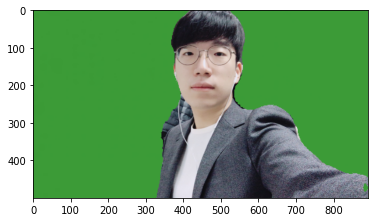

In [41]:
img_concat5 = np.where(img_mask_color5==255, img_orig1, img_bg_blur5)

plt.imshow(cv2.cvtColor(img_concat5, cv2.COLOR_BGR2RGB))
plt.show()

-> 마천가지로 사람 segemant를 딸때 패딩이 보이는 현상 발견

## 3. 해결 방안 제안
    1. 사람 사진에서 뒤에 패딩 부분, 오른쪽 어깨부분 미세한 블러처리 안됨
    - 패딩과 사람을 구분못함, 사용 모델의 클래스 수 20개 그 중 패딩은 없음, 패딩이 있었다면 잘 잡아냈을까? 
        - 세분화된 모델로 추가검증 필요
        - 데이터 증강이나 Fine-tuning이 필요 ; train_pascalvoc_model
    - 오른쪽 어깨부분 즉, 경계면 부분이 매끄럽지 못한것은 모델의 한계로 평가 
        - 경계 부분을 개선할 경우 : 마스크 후처리(가우시안): 경계가 계단처럼 보일 수 있는 부분을 부드럽게 표현
    2. 고양이와 사람이 같이 있는 사진에서 사람의 손과 고양이가 붙어 있는 부분에서 고양이 일부분이 잘림
    
- 단순한 사진에 대해서는 모델이 잘 구분하는 듯 하다.하지만 뒷 배경이 조금이라도 복잡하면 경계면과 분리해야할 객체를 100%로 표현하는 것 같지는 않다.
    사용한 모델에서 후처리 할 수 있는 부분을 최대한 하여 비교해보고 최신 모델과 비교를 진행해 봐야할 듯 하다.